In [29]:
import numpy as np
import pandas as pd
from fractions import Fraction
from math import floor, gcd, log
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT, UnitaryGate, QFTGate
from qiskit.transpiler import CouplingMap, generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler

## 首先解决求阶问题

1. 为了利用相位估计方法来求得阶数，需要构造一个U算子(实际上是一个置换矩阵，因此也是幺正的)和其对应的特征向量(理想情况下应该带有r)，并且实现受控U门的幂次操作(通过模幂运算满足)
2. 对于一个给定的正整数N，设置一个集合Z_N={1,...N-1}，集合中的每个元素与N互质，酉算子为UX = aX(mod N)，x属于Z_N
3. 这样的U对应的特征值可以求得r
4. 对应的特征向量无法制备，观察得，可以利用其特性将态初始化为1，1是U的特征向量的均匀叠加
5. 结果：首先：我们将相位视为：k/r，其中r是阶数，k是某一个特征向量的下标。第二：将态初始化为1后，在后面的过程中，相当于是对某一个下标为k(随机选择的)的特征向量的相位测量

### N=15 a=2例子：

1. 首先构造集合Z_N = {2,4,7,8,11,13,14}
2. 就这个例子而言，之所以只要构造M2和M4，参考下面的b计算
3. 构造模幂算子：M2 ，也就是Ma，其作用到计算基态上：| 2*y mod 15>
|0>    ∣0>
|1>    |2>
|2>    |4>
|3>    |6>
|4>    |8>
|5>    |10>
|6>    |12>
|7>    |14>
|8>    |1>
|9>    |3>
|10>   |5>
|11>   |7>
|12>   |9>
|13>   |11>
|14>   |13>
可以看到计算基态的顺序被打乱了

In [4]:
# 实现模乘算子，即上面对计算基的置换操作
from qiskit import QuantumCircuit

def M2mod15():
    """
    M2 (mod 15)
    """
    b = 2
    U = QuantumCircuit(4)
 
    U.swap(2, 3)
    U.swap(1, 2)
    U.swap(0, 1)
 
    U = U.to_gate()
    U.name = f"M_{b}"
 
    return U

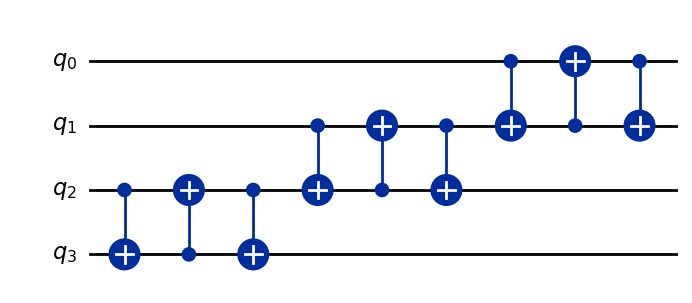

In [5]:
# Get the M2 operator
M2 = M2mod15()

# Add it to a circuit and plot
circ = QuantumCircuit(4)
circ.compose(M2, inplace=True)
circ.decompose(reps=2).draw(output="mpl", fold=-1)

In [8]:
# 创建受控版本
def controlled_M2mod15():
    """
    Controlled M2 (mod 15)
    """
    b = 2
    U = QuantumCircuit(4)
 
    U.swap(2, 3)
    U.swap(1, 2)
    U.swap(0, 1)
 
    U = U.to_gate()
    U.name = f"M_{b}"
    # 注意用法
    c_U = U.control()
 
    return c_U

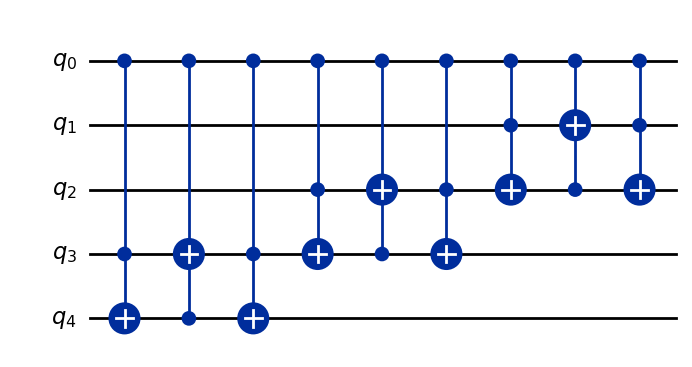

In [11]:
# Get the controlled-M2 operator
controlled_M2 = controlled_M2mod15()
 
# Add it to a circuit and plot
circ = QuantumCircuit(5)
circ.compose(controlled_M2, inplace=True)
circ.decompose(reps=1).draw(output="mpl", fold=-1)

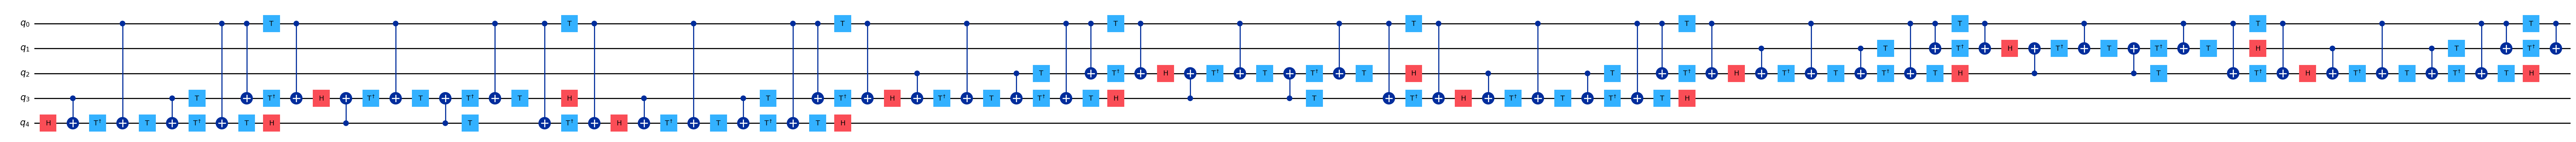

In [12]:
circ.decompose(reps=2).draw(output="mpl", fold=-1)
# ？？

M4，实际上也就是Mb ，其作用到计算基态上：| 4*y mod 15>

In [21]:
def M4mod15():
    """
    M4 (mod 15)
    """
    b = 4
    U = QuantumCircuit(4)
 
    U.swap(1, 3)
    U.swap(0, 2)
 
    U = U.to_gate()
    U.name = f"M_{b}"
 
    return U

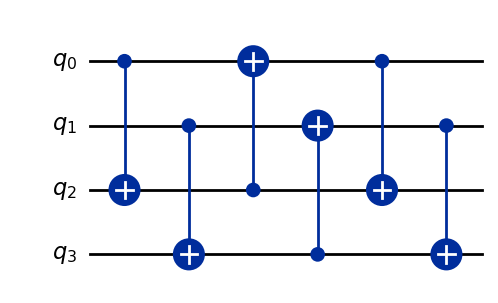

In [22]:
# Get the M4 operator
M4 = M4mod15()
 
# Add it to a circuit and plot
circ = QuantumCircuit(4)
circ.compose(M4, inplace=True)
circ.decompose(reps=2).draw(output="mpl", fold=-1)

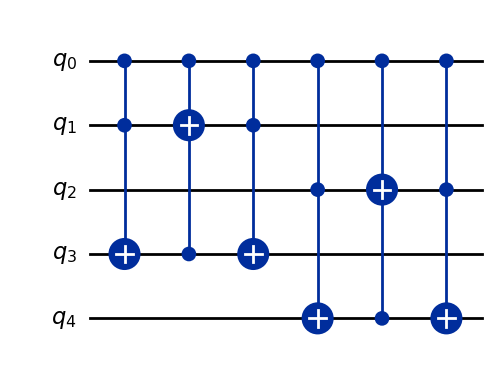

In [23]:
# 受控的M4
def controlled_M4mod15():
    """
    Controlled M4 (mod 15)
    """
    b = 4
    U = QuantumCircuit(4)
 
    U.swap(1, 3)
    U.swap(0, 2)
 
    U = U.to_gate()
    U.name = f"M_{b}"
    c_U = U.control()
 
    return c_U

# Get the controlled-M4 operator
controlled_M4 = controlled_M4mod15()
 
# Add it to a circuit and plot
circ = QuantumCircuit(5)
circ.compose(controlled_M4, inplace=True)
circ.decompose(reps=1).draw(output="mpl", fold=-1)

计算 |a的2的k次 mod N>，k=0,1,2,3,4,5,6,7即控制量子比特数

In [20]:
def a2kmodN(a, k, N):
    """Compute a^{2^k} (mod N) by repeated squaring"""
    for _ in range(k):
        a = int(np.mod(a**2, N))
    return a

通过计算b_list，发现只有2个门需要实现，因为其他的门可以当做是单位门
当b=2时，由计算结果知，此时k==0，可以对应到对应的控制量子比特上
当b=4时，由计算结果知，此时k==1，可以对应到对应的控制量子比特上
其他的都是单位门

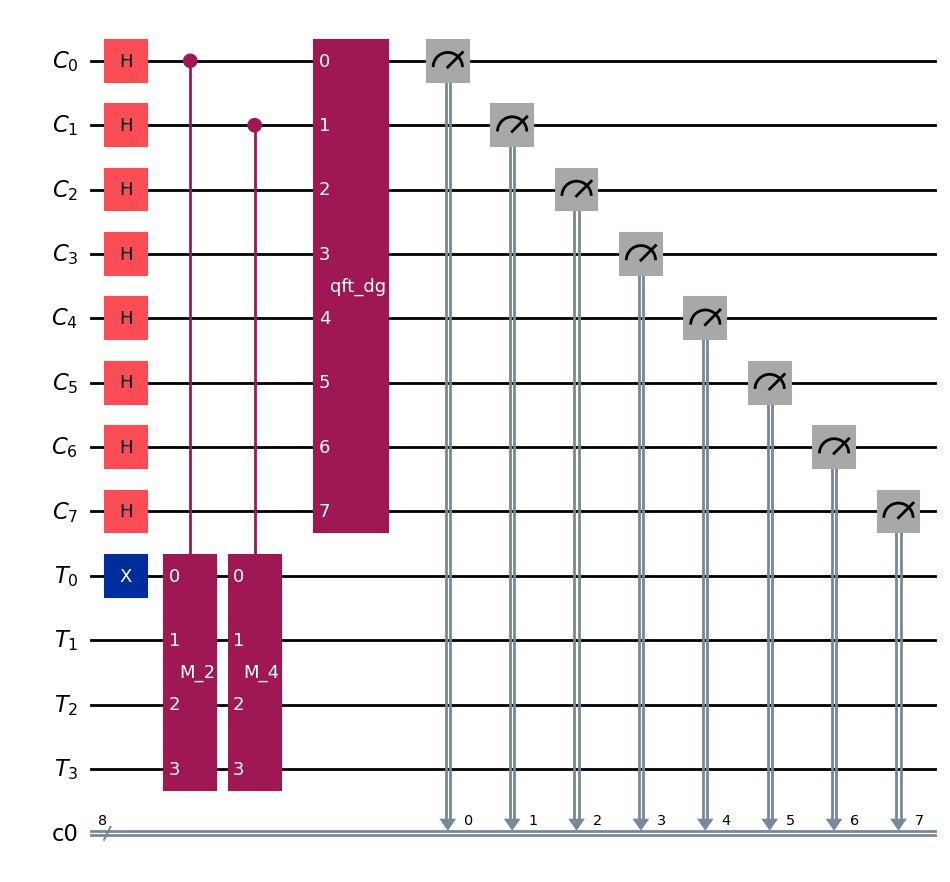

In [36]:
# 定义完整的电路
N = 15
a = 2

# Number of qubits
num_target = floor(log(N - 1, 2)) + 1  # 模幂运算算子比特
num_control = 2 * num_target  # 为了足够的精度，第一寄存器的比特数
 
# List of M_b operators in order
k_list = range(num_control)
b_list = [a2kmodN(2, k, 15) for k in k_list]
 
# Initialize the circuit
control = QuantumRegister(num_control, name="C")
target = QuantumRegister(num_target, name="T")
output = ClassicalRegister(num_control)
circuit = QuantumCircuit(control, target, output)

# Initialize the target register to the state |1>，也就是|0001>
circuit.x(num_control)
 
# Add the Hadamard gates and controlled versions of the
# multiplication gates
for k, qubit in enumerate(control):
    circuit.h(k)
    b = b_list[k]
    if b == 2:
        circuit.compose(
            M2mod15().control(), qubits=[qubit] + list(target), inplace=True
        )
    elif b == 4:
        circuit.compose(
            M4mod15().control(), qubits=[qubit] + list(target), inplace=True
        )
    else:
        continue  # M1 is the identity operator
 
# Apply the inverse QFT to the control register
circuit.compose(QFTGate(num_control).inverse(), qubits=control, inplace=True)
# Measure the control register
circuit.measure(control, output)
circuit.draw("mpl", fold=-1)

使用模拟器得到结果：

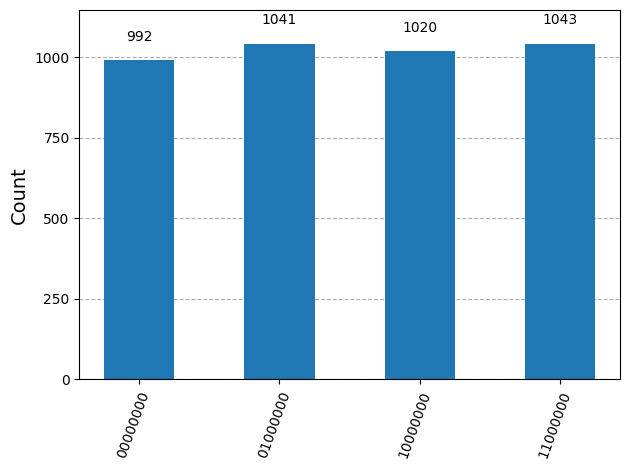

In [40]:
aer_sim = AerSimulator()
shots = 4096
 
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
sampler = Sampler(mode=aer_sim)
new_circ = pm.run(circuit)
job = sampler.run([new_circ], shots=shots)
result = job.result()
answer = result[0].data.c0.get_counts()
plot_histogram(answer)

            Register Output           Phase
0  00000000(bin) =   0(dec)    0/256 = 0.00
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  11000000(bin) = 192(dec)  192/256 = 0.75
测量结果

已经测得相位和s/r非常接近，要找出s和r就要用连分式算法，至于为什么可以查看数论的证明

In [41]:
measured_phases = [0.00, 0.25, 0.50, 0.75]
# Rows to be displayed in a table
rows = []
 
for phase in measured_phases:
    # limit_denominator限制最大分母，如果不限制，那么分布会很大，又因为r<<N，所以我们可以直接选择15作为分母
    frac = Fraction(phase).limit_denominator(15)
    rows.append(
        [phase, f"{frac.numerator}/{frac.denominator}", frac.denominator]
    )
 
# Print the rows in a table
headers = ["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.50      1/2            2
3   0.75      3/4            4


## 至此就完成了求阶问题，接下来就是完成整数分解问题！

这一部分是完全经典的，不需要量子计算，大多数是数论的结果，就先不看了